## Code without library

In [ ]:
GRADIENT_FILTER = [-1, 0, 1]
NUM_OF_BINS = 9
CELL_SIZE = 8
BLOCK_SIZE = (16, 16)
DETECTION_WINDOW_SIZE = (64, 128)

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 1) Load Test Image
img = cv2.imread('./man.jpg')

# Resize to 64x128 (width x height)
resized_img = cv2.resize(img, DETECTION_WINDOW_SIZE)
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')

In [ ]:
# Calculate gradients
import numpy as np

image = gray_img
image = image.astype(np.float32)

# Pad the image to handle borders
padded_image = np.pad(image, ((1,1), (1,1)), mode='edge')

gradient_x = np.zeros_like(image, dtype=np.float32)
gradient_y = np.zeros_like(image, dtype=np.float32)

rows, cols = image.shape

for i in range(rows):
    for j in range(cols):
        window = padded_image[i:i+3, j:j+3]

        gradient_x[i, j] = (window[1, 0] * -1) + (window[1, 2] * 1)
        gradient_y[i, j] = (window[2, 1] * -1) + (window[0, 1] * 1)

# Compute gradient magnitude and orientation
magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
orientation = np.arctan2(gradient_y, gradient_x) * 180 / np.pi  # in degrees


In [ ]:
cell_size = CELL_SIZE[0]
num_bins = NUM_OF_BINS

# Get image dimensions
height, width = magnitude.shape
    
# Calculate cell grid dimensions
num_cells_y = height // cell_size
num_cells_x = width // cell_size
    
# Make sure orientations are in range 0-180 degrees
orientation = np.mod(orientation, 180)
    
# Initialize histogram array
histograms = np.zeros((num_cells_y, num_cells_x, num_bins))
    
# Calculate bin width and bin centers
bin_width = 180 / num_bins


In [57]:
# Get cell size
cell_size = CELL_SIZE[0]
num_bins = NUM_OF_BINS

# Get image dimensions
height, width = magnitude.shape
    
# Calculate cell grid dimensions
num_cells_y = height // cell_size
num_cells_x = width // cell_size
    
# Make sure orientations are in range 0-180 degrees
# Convert negative angles to positive equivalents
orientation = np.mod(orientation, 180)
    
# Initialize histogram array
histograms = np.zeros((num_cells_y, num_cells_x, num_bins))
    
# Calculate bin width - for 9 bins covering 0-180°, each bin is 20° wide
bin_width = 180 / num_bins
    
# For each cell
for y in range(num_cells_y):
    for x in range(num_cells_x):
        # Define cell boundaries
        y_start = y * cell_size
        y_end = (y + 1) * cell_size
        x_start = x * cell_size
        x_end = (x + 1) * cell_size
        
        # Extract cell region
        cell_magnitudes = magnitude[y_start:y_end, x_start:x_end]
        cell_orientations = orientation[y_start:y_end, x_start:x_end]
        
        # Flatten the cell arrays for easier processing
        cell_magnitudes = cell_magnitudes.flatten()
        cell_orientations = cell_orientations.flatten()
        
        # For each pixel in the cell
        for i in range(len(cell_magnitudes)):
            # Get magnitude and orientation
            mag = cell_magnitudes[i]
            angle = cell_orientations[i]
            
            binel, rem = np.divmod(angle, bin_width)

            weightR = rem*1.0/bin_width
            weightL = 1 - weightR

            deltaR = mag * weightR
            deltaL = mag * weightL

            binL = int(binel)
            binR = np.mod(binL+1, num_bins)
            histograms[y, x, binL] += deltaL
            histograms[y, x, binR] += deltaR
            

In [ ]:
# Define block parameters
block_size = (2, 2)  # 2x2 cells = 16x16 pixels (assuming 8x8 pixel cells)
block_stride = (1, 1)  # 8-pixel spacing = 1 cell stride

# Calculate the number of blocks
num_blocks_y = num_cells_y - block_size[0] + 1
num_blocks_x = num_cells_x - block_size[1] + 1

# Initialize the normalized feature vector
hog_features = []

# Process each block with the specified stride
for y in range(0, num_cells_y - block_size[0] + 1, block_stride[0]):
    for x in range(0, num_cells_x - block_size[1] + 1, block_stride[1]):
        # Extract block histograms (2x2 cells)
        block_hist = histograms[y:y+block_size[0], x:x+block_size[1], :].flatten()
        
        # L2-norm
        l2_norm = np.sqrt(np.sum(block_hist**2) + 1e-10)  # Small epsilon to avoid division by zero
        
        normalized_block = block_hist / l2_norm
        
        clip_threshold = 0.2
        normalized_block = np.clip(normalized_block, 0, clip_threshold)
        
        l2_norm_again = np.sqrt(np.sum(normalized_block**2) + 1e-10)
        normalized_block = normalized_block / l2_norm_again
        
        hog_features.append(normalized_block)

hog_features = np.array(hog_features)

hog_features_reshaped = hog_features.reshape(num_blocks_y, num_blocks_x, -1)

In [ ]:
V

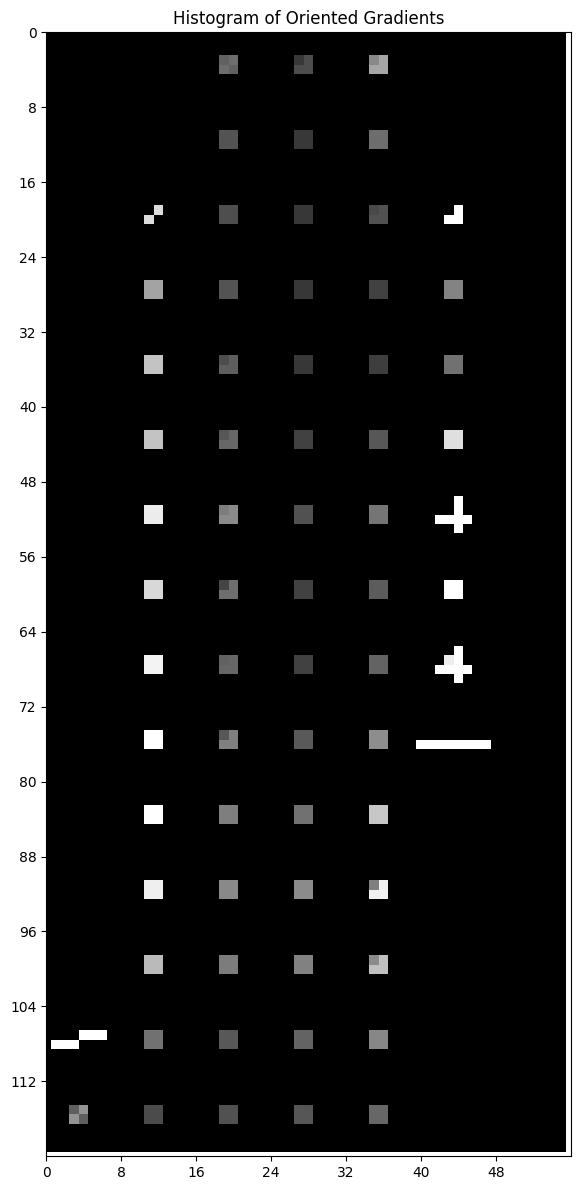

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from skimage import draw

def visualize_hog_like_image(hog_features, figsize=(8, 12), cell_size=8, scale_factor=1.0):
    rows, cols, orientations = hog_features.shape
    
    # Calculate the size of the output image
    img_height = rows * cell_size
    img_width = cols * cell_size
    
    # Create a black background image
    hog_image = np.zeros((img_height, img_width), dtype=np.float32)
    
    # For each cell in the grid
    for y in range(rows):
        for x in range(cols):
            # Center coordinates of the current cell
            center_y = (y + 0.5) * cell_size
            center_x = (x + 0.5) * cell_size
            
            # Get histogram for this cell
            histogram = hog_features[y, x]
            
            # Normalize the histogram
            if np.sum(histogram) > 0:
                histogram = histogram / np.sum(histogram)
            
            # Draw lines for each orientation bin
            for orient_idx in range(orientations):
                # Calculate angle in radians (assuming angles are evenly distributed from 0 to 180 degrees)
                angle = orient_idx * (np.pi / orientations)
                
                # Scale line length based on histogram value
                line_length = histogram[orient_idx] * cell_size * 0.5 * scale_factor
                
                if line_length > 0:
                    # Calculate line endpoints
                    start_y = int(center_y - line_length * np.sin(angle))
                    start_x = int(center_x - line_length * np.cos(angle))
                    end_y = int(center_y + line_length * np.sin(angle))
                    end_x = int(center_x + line_length * np.cos(angle))
                    
                    # Ensure endpoints are within image boundaries
                    start_y = max(0, min(start_y, img_height - 1))
                    start_x = max(0, min(start_x, img_width - 1))
                    end_y = max(0, min(end_y, img_height - 1))
                    end_x = max(0, min(end_x, img_width - 1))
                    
                    # Draw the line using Bresenham's algorithm
                    rr, cc = draw.line(start_y, start_x, end_y, end_x)
                    valid_idx = (rr >= 0) & (rr < img_height) & (cc >= 0) & (cc < img_width)
                    
                    # Set intensity based on histogram value
                    hog_image[rr[valid_idx], cc[valid_idx]] = np.maximum(
                        hog_image[rr[valid_idx], cc[valid_idx]], 
                        histogram[orient_idx] * scale_factor
                    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Display the image with a dark background and light lines
    ax.imshow(hog_image, cmap='gray', vmin=0, vmax=0.2)  # Adjust vmax to control contrast
    
    # Set title
    ax.set_title("Histogram of Oriented Gradients")
    
    # Set axis ticks
    x_ticks = np.arange(0, img_width, cell_size)
    y_ticks = np.arange(0, img_height, cell_size)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    
    # Add grid lines if desired (optional - not in the example image)
    # ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Set proper axis limits
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_height, 0)  # Reverse y-axis to match image coordinates
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Create random HOG features with shape (15, 7, 36)
np.random.seed(42)  # For reproducibility
hog_features = np.random.rand(15, 7, 36)

# Visualize the HOG features with the same look as the example
visualize_hog_like_image(hog_features_reshaped, scale_factor=1.0)  # Adjust scale_factor as needed



## Using Library

(3780,)
(128, 64)


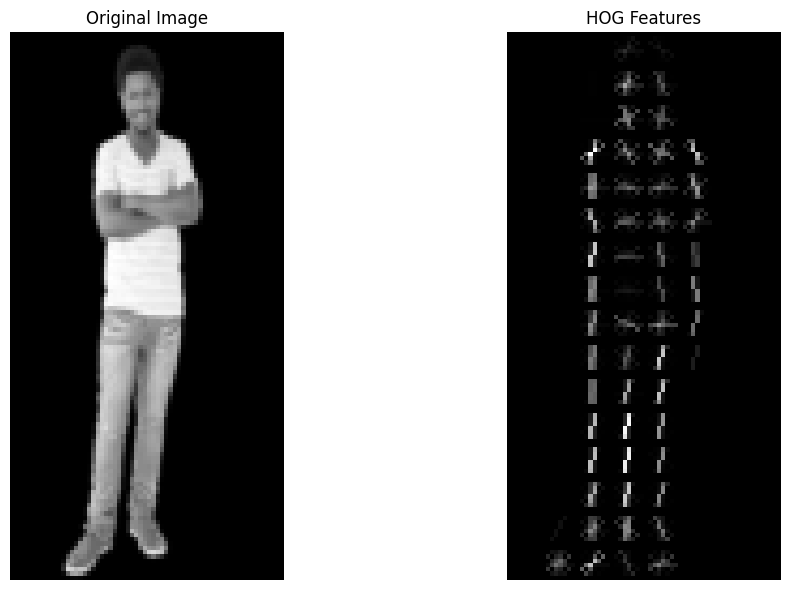

Feature vector length: 3780
Feature vector shape: (3780,)


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform
from skimage.feature import hog
from skimage import exposure

def compute_hog_features(image_path):
    # Read the image
    img = io.imread(image_path)
    
    # Resize to 64x128 pixels if needed
    if img.shape[0] != 128 or img.shape[1] != 64:
        img = transform.resize(img, (128, 64), anti_aliasing=True)
    
    # Convert to grayscale (handle both RGB and RGBA images)
    if len(img.shape) > 2:
        # For RGBA images (4 channels), remove the alpha channel first
        if img.shape[2] == 4:
            img = img[:, :, :3]
        gray_img = color.rgb2gray(img)
    else:
        gray_img = img
    
    # Compute HOG features with specified parameters
    features, hog_image = hog(
        gray_img,
        orientations=9,             # 9 orientation bins
        pixels_per_cell=(8, 8),     # 8x8 pixel cells
        cells_per_block=(2, 2),     # 16x16 blocks (2x2 cells)
        block_norm='L2-Hys',        # L2-Hys normalization
        visualize=True,
        feature_vector=True,
        transform_sqrt=False,       # No gamma correction
    )

    print(features.shape)
    print(hog_image.shape)
    
    return gray_img, features, hog_image

def visualize_hog(image_path):
    # Compute HOG features
    gray_img, features, hog_image = compute_hog_features(image_path)
    
    # Rescale HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    # Visualize original and HOG images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(gray_img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(hog_image_rescaled, cmap='gray')
    ax2.set_title('HOG Features')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Feature vector length: {len(features)}")
    print(f"Feature vector shape: {features.shape}")
    
    return features

image_path = "man.jpg"
features = visualize_hog(image_path)